<a href="https://colab.research.google.com/github/marcocaramanti/MLPNS_MCaramanti/blob/main/W7_NN_part2/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"] = "nearest"
# Cioè niente interpolazione fra i pixel dell'immagine
plt.rcParams["image.cmap"] = "gist_gray"

In [4]:
cd /content/drive/MyDrive/MLPNS2023

/content/drive/MyDrive/MLPNS2023


In [5]:
ls

higgsBoson/     log/   model.png  spm-20210427T111354Z-001.zip  wine.names
kaggleTitanic/  logs/  spm/       wine.data


In [6]:
# !unzip spm-20210427T111354Z-001.zip

In [7]:
# I dati da leggere sono tutti numpy array. Sono salvati in formato binario
# sfruttando il pacchetto pickle

data = np.load("spm/train_good_all.npy")
# Usiamo questo sia come trainset sia testset: splitteremo con l'apposita
# funzione

In [8]:
data.shape

(1302, 64, 64)

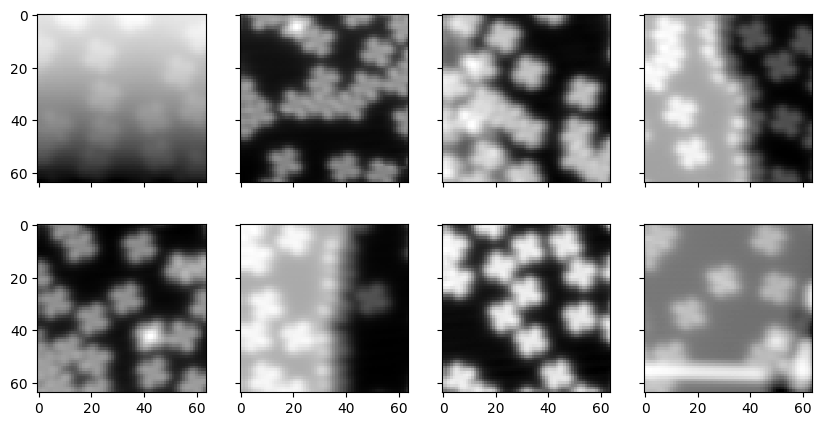

In [9]:
# Sono 1302 immagini, ciascuna 64x64
# Plottiamo le prime otto

fig, ax = plt.subplots(2, 4, figsize=[10,5], sharex=True, sharey=True)
for ii in range(8):
  ax[ii // 4, ii % 4].imshow(data[ii])

La nostra NN servirà per identificare la posizione di oggetti nelle immagini. L'oggetto saranno queste molecole a croce. Per farlo servono esempi per sapere dove sono le molecole e dove non sono. Creeremo convolutional NN per farlo sulla base del fatto che sanno le soluzioni, cioè cosa sono molecole e cosa no. Una CNN impara le weight map, cioè le forme con cui fare la convoluzione.

(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

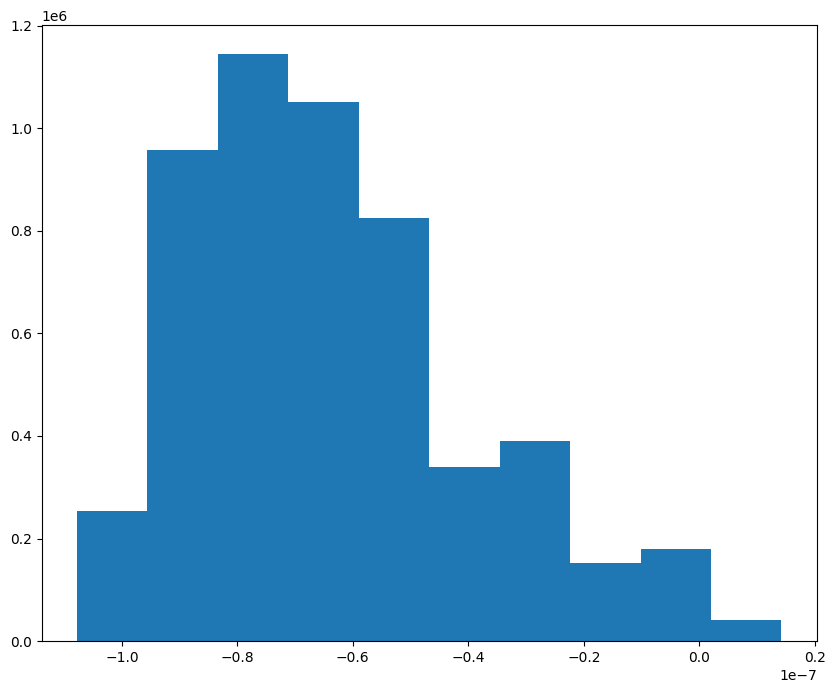

In [10]:
# Per capire il range dei dati estraiamo tutti i pixel e facciamo un istogramma

plt.hist(data.flatten())

Il range va da -1 a $10^{-7}$. Range non buono: può dare problemi numerici. Solitamente allora si fa **min-max preprocessing** e si scala tutto fra 0 e 1.

$$
\frac{D - \min{D}}{\text{range}(D)}
$$

In [11]:
norm = (data - data.min(axis=(1,2), keepdims=True))/(
    data.max(axis=(1,2), keepdims=True) - data.min(axis=(1,2), keepdims=True))

# axis=(1,2) dice di prendere il minimo sugli assi 1 e 2, quelli su cui si
# trovano i valori dei pixel per come è organizzato il dataset. keepsdims=True
# fa sì che non cambino le dimensioni dell'array

In [12]:
norm.shape

(1302, 64, 64)

In [13]:
norm.min(), norm.max()

(0.0, 1.0)

Tipicamente lo scaling per immagini è min-max. Casi particolari: se c'è altro contrasto e importano valori nella coda si usano altrimenti metodi (comune in astrofisica).

Ora carichiamo le labels da passare al NN. Le labels sono separate fra annotazioni positive e negative. `pos` darà la posizione delle molecole, `neg` la posizione di altre cose che non sono molecole.

In [14]:
pos = np.load("spm/spm_struct_pos.npy")
neg = np.load("spm/spm_struct_neg.npy")

In [15]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [16]:
# Ogni label è un vettore di tre valori: numero immagine, pos asse x, pos asse y

pos[0]

array([30, 25, 51])

In [17]:
pos.max(axis=0)
# La cosa curiosa è che il numero dell'immagine è il terzo valore dei tre,
# i primi due sono la posizione x e y, cioè
# (posizione x, posizione y, numero immagine)

array([  62,   62, 1300])

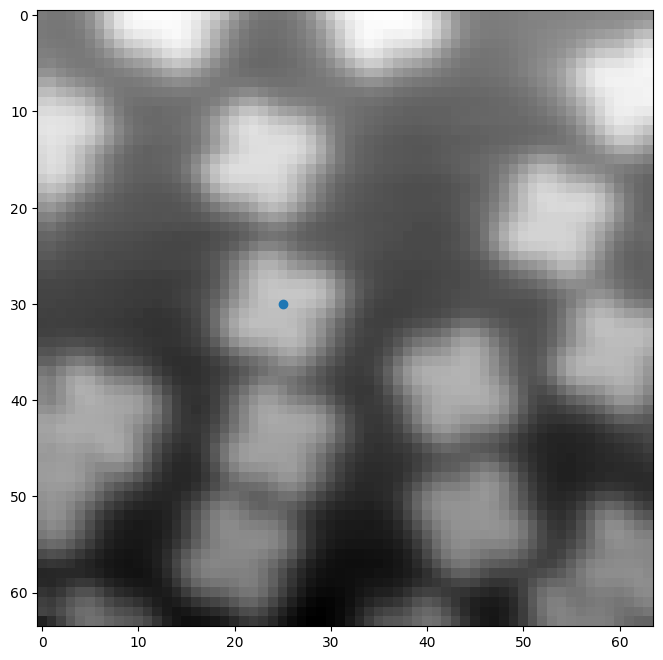

In [18]:
# Controlliamo di leggere le label nel modo corretto
# Plottiamo l'immagine indicata da pos[0] (vedi prima), cioè la 51

plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1], pos[0][0], 'o')
# In un'immagine l'asse y è il primo asse, l'asse x il secondo

Per semplificare il problema, creiamo immagini che sono molecole e immagini che contengono cose che non sono molecole. Creiamo quindi un input dataset che contiene gli oggetti che vogliamo. Il codice ispezionerà separatamente pezzi dell'immagine e dirà se sono molecole o no e darà i valori dei pixel che corrispondono a molecole. Questo è uno sliding window CNN.

Ci sono poi altri metodi più complicati per fare questo esercizio (es. YOLO e RCNN).

In [19]:
# Creiamo i postage stamp, che sono della dimensione più o meno
# della molecole e centrati sulla posizione della molecola.

wid = 10 # semilarghezza stamp. È di fatto un hyperparameter
stmp_pos = [] # mettiamo i valori in una lista che poi convertiremo in array

for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]
  # Vogliamo assicurarci di non essere al limite dell'immagine
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_pos = np.array(stmp_pos)

In [20]:
stmp_pos.shape

(389, 20, 20)

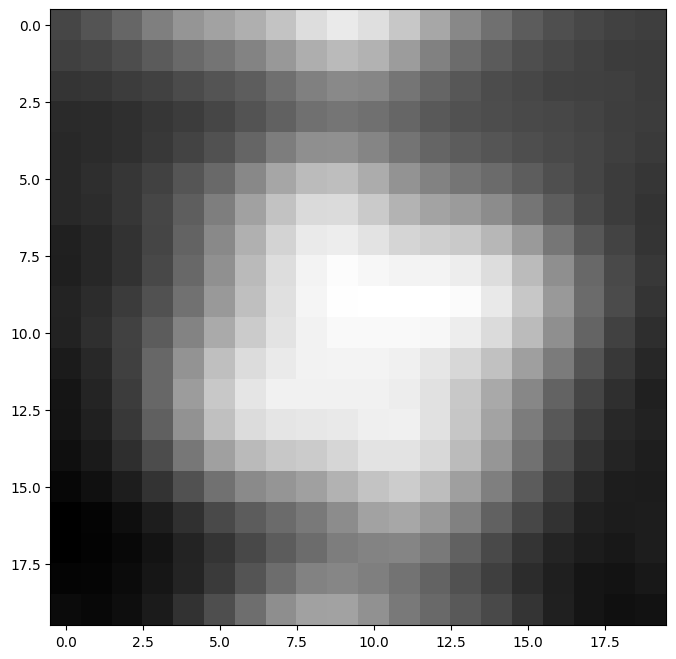

In [21]:
plt.imshow(stmp_pos[0])

In [22]:
# Ora rifacciamo con le label negative

wid = 10
stmp_neg = []

for ii in range(pos.shape[0]):
  trow, tcol, tind = neg[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_neg = np.array(stmp_neg)

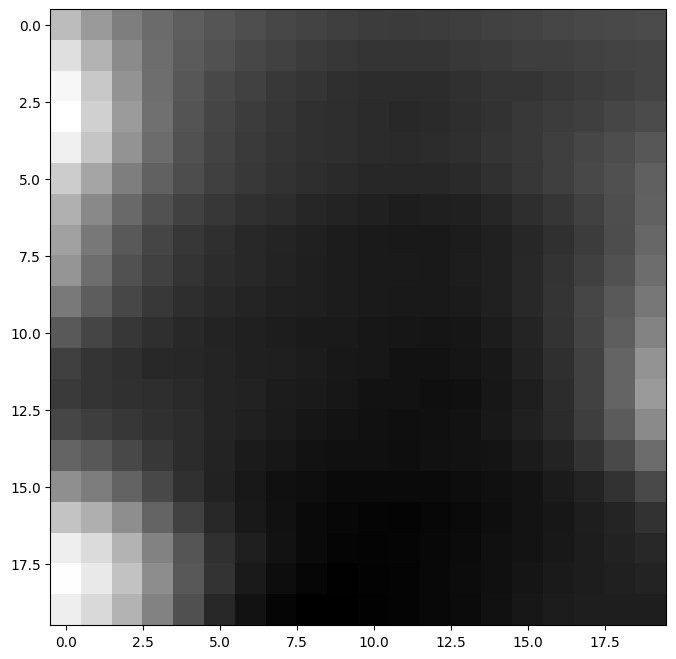

In [23]:
plt.imshow(stmp_neg[0])

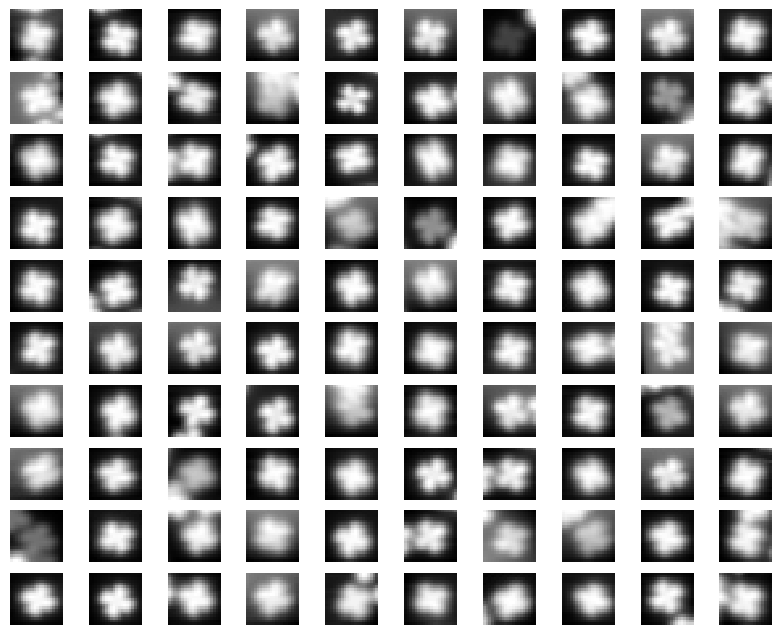

In [24]:
# Plottiamo alcune label positive
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

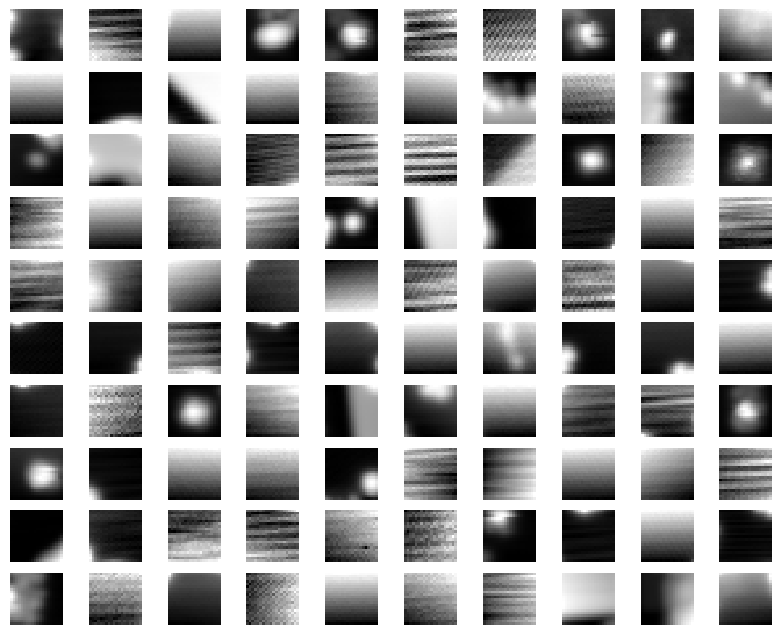

In [25]:
# Plottiamo alcune label negative
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [26]:
# Feat è la concatenazione dei due array di stamp positivi e negativi
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)

# Ora creiamo il target: deve essere 0 per tutti i valori negativi, 1 per quelli
# positivi
targ = np.concatenate((np.zeros(stmp_neg.shape[0]),
                                 np.ones(stmp_pos.shape[0])))

In [27]:
feat.shape

(874, 20, 20)

In [28]:
targ.shape

(874,)

In [29]:
# Creiamo training e test set

# Ci può essere un problema nello split: le forme nel positive set (a meno di
# rotazione) sono tutte simili, mentre nel negative set no. Quindi è utile che 
# il negative set sia più grande in modo da avere più esempi.
# Come accortezza nel fare lo split bisogna mescolare i dati, altrimenti (es)
# nel train vengono messi prevalentemente solo dati negativi. Quindi
# mettiamo shuffle=True

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ,
                                                      random_state=302,
                                                      shuffle=True)
feat_tr.shape

(655, 20, 20)

In [30]:
# Keras quando si usano convolutional 2d layers si aspetta immagini in tre
# canali (RGB). Noi però abbiamo B/N. Allora dobbiamo cambiare la dimensione 
# degli array facendo in modo che il terzo asse abbia dim 1.

feat_tr = np.expand_dims(feat_tr, axis=3)
feat_te = np.expand_dims(feat_te, axis=3)
feat_tr.shape

(655, 20, 20, 1)

Creiamo una NN
- conv2d 16 neurons
- maxpool2d 2x2
- conv2d 32 neurons
- maxpol2d 2x2
- flatten
- dense 64 neurons
- dense 2 neurons

In [31]:
# kernel_size è la dimensione della map, cioè l'oggetto con cui si va la
# convoluzione
# In questo esempio tutte le molecole (e quindi il kernel) hanno la stessa
# dimensione. In altri casi le dimensioni potrebbero essere diverse.
# padding="same" vuol dire che l'output deve avere la stessa dimensione
# dell'input
# Come attivazione nei convolutional layer si usa di solito reLU
# input_shape dice che dati aspettarsi nell'input. Si mette solo nel primo
# layer. Nel nostro caso è la dim del postage stamp

layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1),
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(2)

layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer4 = keras.layers.MaxPool2D(2)

layer5 = keras.layers.Flatten()

# Flatten mette i pixel (che sono organizzati in layer bidimensionali)
# in una riga.

layer6 = keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=keras.regularizers.l2(0.001))

layer7 = keras.layers.Dense(2, activation="softmax")
# Dato che vogliamo un output binario, usiamo un'attivazione che va molto
# vicino a 1 o 0 (la step function non si usa perché non differenziabile).
# Si usa di solito tanh o softmax


layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

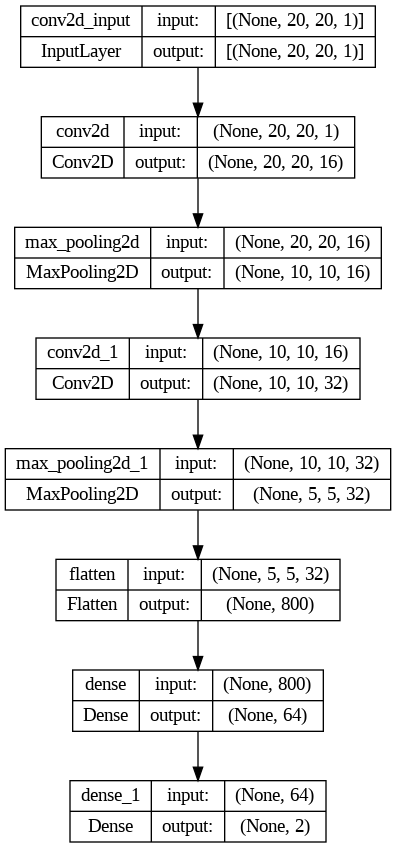

In [32]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
# Questo codice ci servirà per usare TensorBoard

from datetime import datetime

# !mkdir -p log logs/fitnew
logdir = "logs/fitnew" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
# Per il modello precedente usavamo la L1 come loss function perché facevamo
# regressione (1 neurone output). Ora facciamo classificazione (2 neuroni out)
# quindi ci serve una loss function categorica.

# Nel training monitoriamo la metrica accuracy

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics="accuracy")

In [35]:
# Salviamo il fit perché così potremo plottare la loss function
# Minibatching: divide i dati in input in subset che per ogni epoca vengono
# trainati separatamente. Questo mitiga l'overfitting. Per scegliere questo
# si dà la batch_size.
# validation_split=0.1 dice di fare internamente una cross validation con il 10%
# dei dati

history = model.fit(feat_tr, targ_tr, epochs=50, batch_size=50,
                    validation_split=0.1,
                    callbacks=[tensorboard_callback])

# Vengono mostrate separaetamente le metriche per il training set e per 
# la validation

Epoch 1/50
12/12 [==============================] - 11s 41ms/step - loss: 0.7279 - accuracy: 0.6961 - val_loss: 0.5822 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 0.5367 - accuracy: 0.9185 - val_loss: 0.3863 - val_accuracy: 0.9394
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3927 - accuracy: 0.9083 - val_loss: 0.3353 - val_accuracy: 0.9091
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3206 - accuracy: 0.9134 - val_loss: 0.3123 - val_accuracy: 0.9242
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2710 - accuracy: 0.9406 - val_loss: 0.2552 - val_accuracy: 0.9091
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2347 - accuracy: 0.9474 - val_loss: 0.2573 - val_accuracy: 0.9242
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2060 - accuracy: 0.9559 - val_loss: 0.2361 - val_accuracy: 0.9091
Epoch 8/50
12/12 [

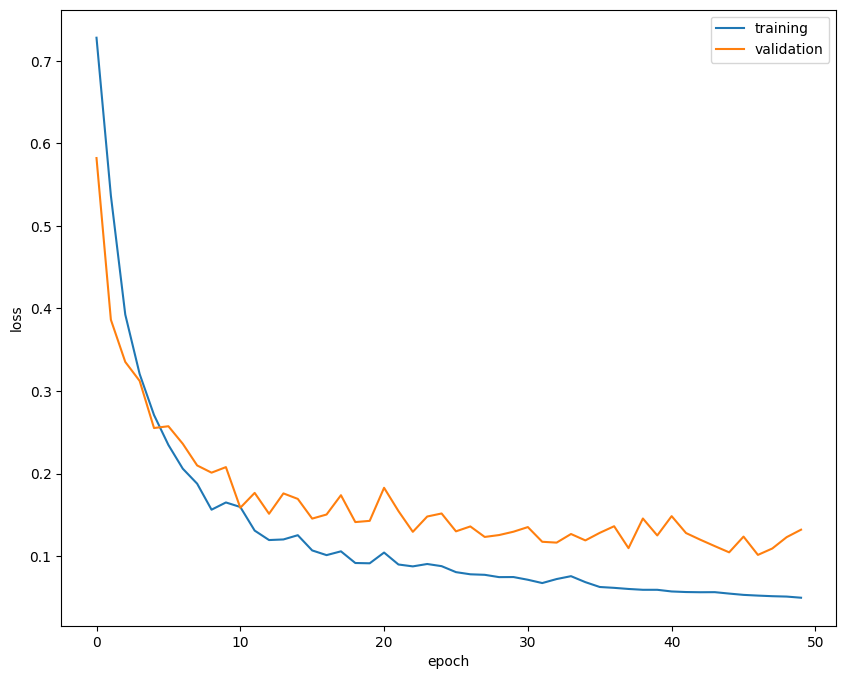

In [36]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

C'è un leggero overfitting ma non importante: la distanza fra le due curve rimane costante.

Vediamo che è presente del rumore che si manifesta come sbalzi. Di solito si può provare a diminuire sbalzi diminuendo il learning rate.

In ogni modo le curve sono tutto sommato buone.

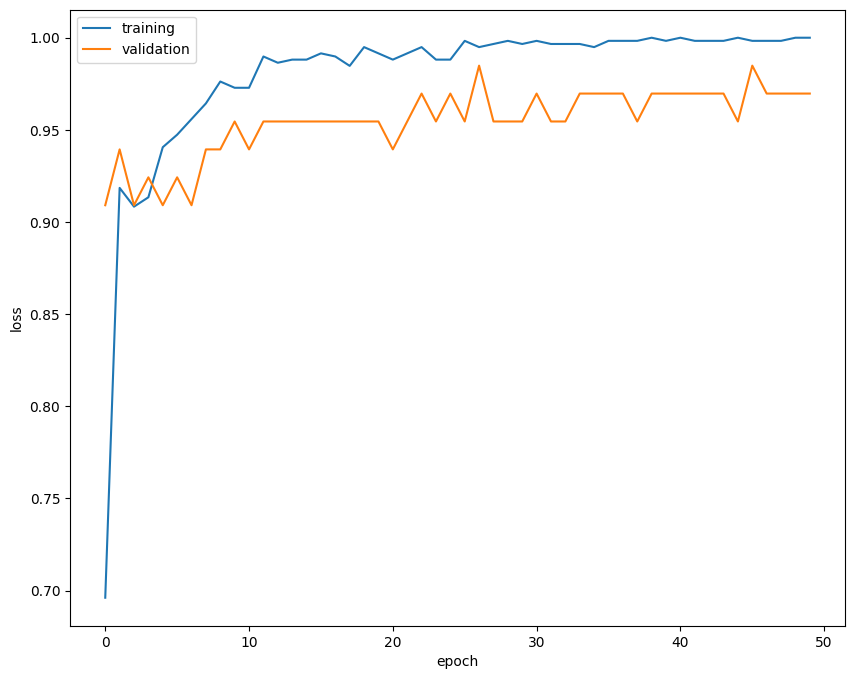

In [37]:
# Proviamo a guardare l'accuracy

plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [38]:
# Andiamo a vedere l'accuratezza sul train e sul test

loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)
print("{:.2f}, {:.2f}, {:.2f}, {:.2f},".format(
    loss_tr, acc_tr, loss_te, acc_te))

7/7 [==============================] - 0s 12ms/step - loss: 0.1036 - accuracy: 0.9909
0.06, 1.00, 0.10, 0.99,


In [42]:
# Per monitorare il NN si può usare un pannello interattivo detto TensorBoard

# %load_ext tensorboard
# %tensorboard --logdir logs

Il nostro CNN riesce quindi a riconoscere le particelle in un'immagine 20x20. Però noi vogliamo che lo faccia in immagini 64x64!

Questo NN è un **object recognition NN**, cioè riconosce se c'è un'oggetto specifico nell'immagine. Vogliamo che diventi un **object-detection NN**, cioè che trova dove è l'oggetto nell'immagine. Possiamo allora prima preparare francobolli dell'immagine e dare questi al NN. Siccome la classificazione è binaria ma probabilistica, questo consentirà non solo di sapere se c'è l'oggetto ma anche qual è il centro.

In [43]:
pos[0]

array([30, 25, 51])

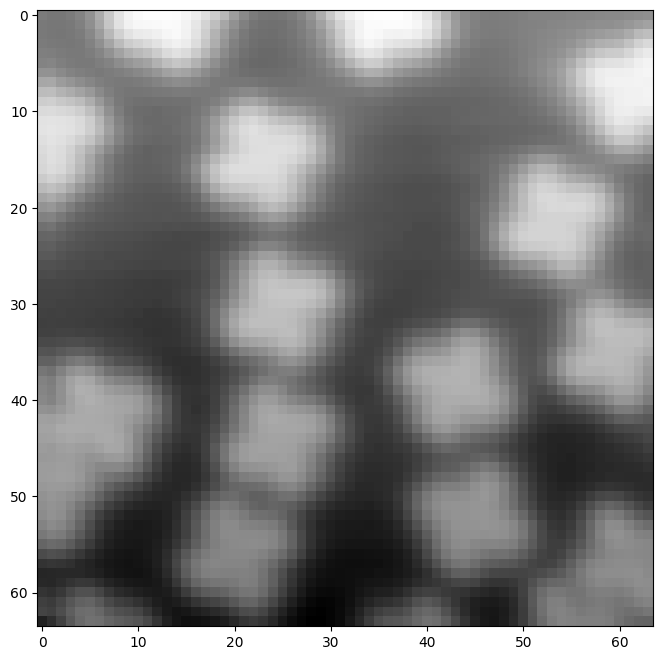

In [48]:
plt.imshow(norm[51])

In [49]:
# Creiamo una copia dell'immagine per essere sicuri di non "romperla"

img = norm[51].copy()
# Serve il metodo copy(), altrimenti in Python img punterebbe semplicemente
# a norm[51]

In [51]:
# Creiamo i postage stamps

nrow, ncol = img.shape

# Prepariamo un contenitore che conterrà i postage stamps. A differenza di prima,
# ora sappiamo già la dimensione del contenitore e quindi usiamo direttamente
# i numpy array, che hanno proprietà computazionali migliori
# Qual è il numero dei postage stamps? La posizione del centro deve essere
# almeno a distanza wid da entrambi i bordi

stamps = np.zeros(((nrow - wid * 2) * (ncol - wid * 2), 2 * wid, 2 * wid))

In [52]:
stamps.shape

(1936, 20, 20)

In [53]:
# Ora aggiungiamo i postage stamps

kk = 0

for ii in range(wid, nrow - wid):
  for jj in range(wid, ncol - wid):
    stamps[kk] = img[ii-wid:ii+wid, jj-wid:jj+wid]
    kk += 1
  
feat_stmp = np.expand_dims(stamps, axis=3)

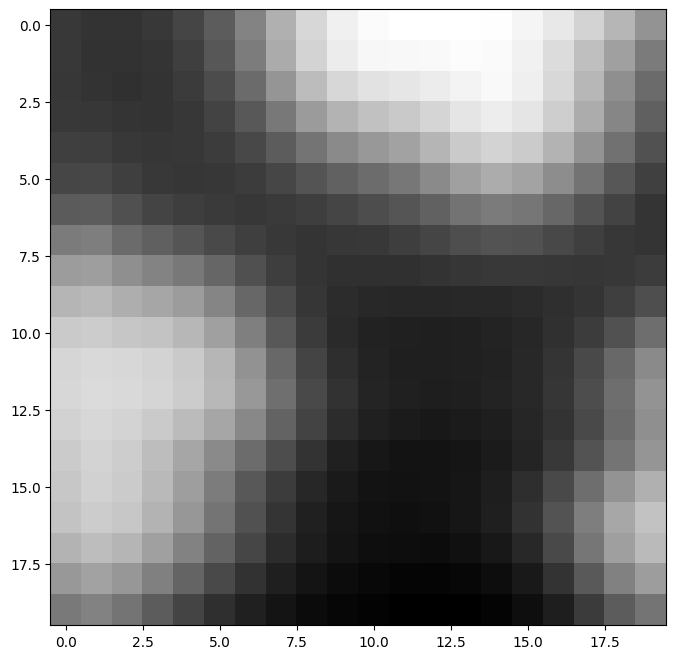

In [55]:
# Proviamo a guardare il primo stamp

plt.imshow(feat_stmp[0])

In [56]:
# Ora abbiamo gli input da dare al modello: possiamo fare la predizione

pred = model.predict(feat_stmp)

61/61 [==============================] - 0s 3ms/step


In [60]:
pred.shape

(1936, 2)

In [61]:
# In pred ci sono i risultati per ogni dato di input, cioè per ogni stamp.
# Le due colonne si riferiscono ai due neuroni: la prima dà la probl di
# classificazione negativa, la seconda positiva

pred[0]

array([1.000000e+00, 3.207963e-11], dtype=float32)

In [62]:
# Il NN è praticamente certo che nel primo stamp non ci sia una molecola

# Per vedere il risultato, creiamo un'immagine che contiene la classificazione

pimg = np.zeros(img.shape)

# Nella nuova immagine mettiamo il risultato della classificazione. Facciamo
# attenzione al fatto che abbiamo lasciato fuori il bordo. Prendiamo le
# classificazioni positive (assumiamo che se la prob negativa è alta,
# quella positiva sarà bassa e viceversa)
pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid,
                                                      ncol - 2 * wid)

# Dobbiamo usare reshape perché pred è un vettore riga

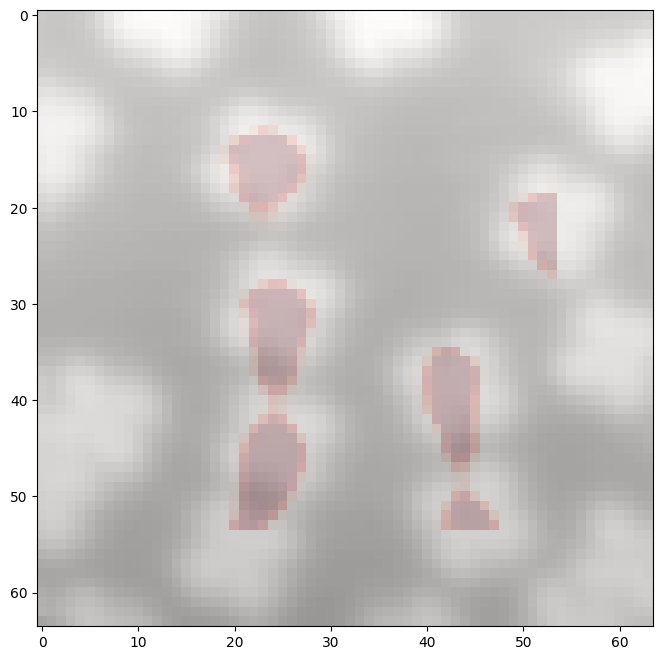

In [63]:
# Ora vediamo il risultato

plt.imshow(img, alpha=0.5)
plt.imshow(pimg, cmap="Reds", alpha=0.2)

# Notiamo che si nota la presenza sui bordi. Noi abbiamo fatto la predizione
# stando dentro, quindi non diciamo niente su eventuali molecole sui bordi.
# Inoltre abbiamo un gradiente che (si spera) abbia il picco nel centro 
# della molecola

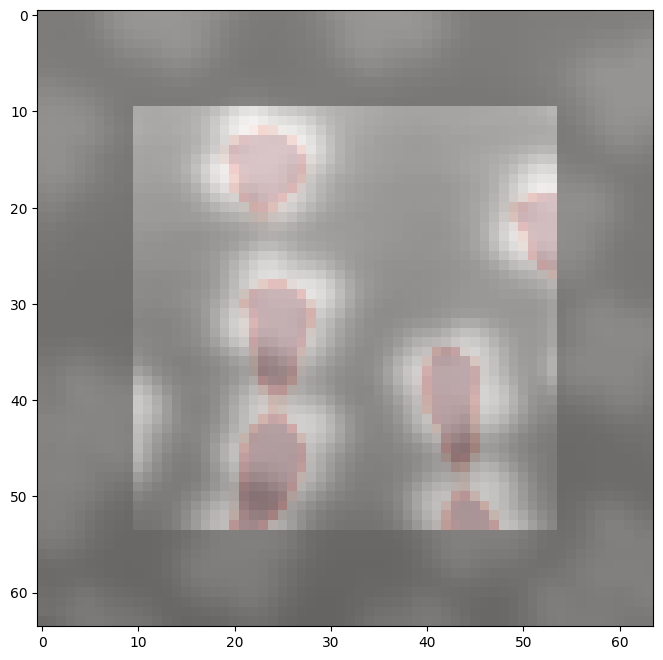

In [65]:
# Stesso codice ma con il bordo

plt.imshow(img, alpha=0.5)
actualimg = img.copy()
actualimg[:wid,:] = 0
actualimg[-wid:,:] = 0
actualimg[:,:wid] = 0
actualimg[:,-wid:] = 0
plt.imshow(actualimg, alpha=0.5)
plt.imshow(pimg, cmap="Reds", alpha=0.2)

In [66]:
# Possiamo vedere i pesi all'ultima iterazione della NN

model.layers[0].weights[0]

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 16) dtype=float32, numpy=
array([[[[-2.07331292e-02,  5.78485392e-02,  6.14339299e-02,
           4.26684283e-02, -4.07382175e-02,  2.89662927e-02,
           5.43207722e-03,  1.07196406e-01,  4.62027527e-02,
           3.36197292e-10, -1.11374311e-01, -5.43407761e-02,
           5.45362495e-02, -1.25673681e-01,  1.54871051e-03,
          -8.01917613e-02]],

        [[-9.42751765e-02,  6.83225915e-02,  4.33370285e-02,
          -6.62452634e-03,  1.37184724e-01, -9.32645649e-02,
          -7.72883892e-02, -8.82483320e-04,  1.04297668e-01,
          -6.20044283e-09, -1.01031149e-02,  5.79131357e-02,
          -2.90570650e-02, -8.66350010e-02,  7.06850514e-02,
          -5.35526462e-02]],

        [[ 6.92983270e-02, -1.23274446e-01, -1.94809679e-02,
           3.26887593e-02, -4.68221121e-02, -9.01401415e-02,
          -3.07382718e-02,  1.71015970e-02, -2.72441246e-02,
           3.18800309e-03,  1.47034330e-02, -3.46604027e-02,
           5.

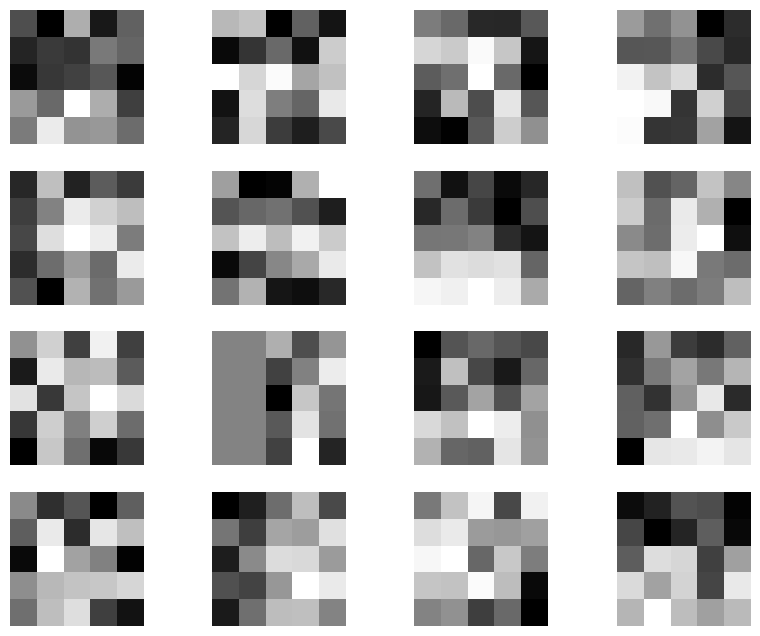

In [68]:
# Possiamo anche visualizzare le weight maps

tmp_ = model.layers[0]

fig, ax = plt.subplots(4, 4)
for ii in range(16):
  ax[ii // 4, ii % 4].imshow(tmp_.weights[0][:,:,0,ii])
  ax[ii // 4, ii % 4].axis("off")